In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nips-papers/paper_authors.csv
/kaggle/input/nips-papers/papers.csv
/kaggle/input/nips-papers/authors.csv
/kaggle/input/nips-papers/database.sqlite


# About NeurIPS and the dataset 
**Neural Information Processing Systems** abbreviated as NeurIPS is one of the top machine learning conferences in the world. It covers topics ranging from deep learning and computer vision to cognitive science and reinforcement learning.

The dataset used in this notebook includes all the paper published between 1987 and 2017 in NeurIPS. There are three csv file **"authors.csv"**, **"papers.csv"** and **"paper_authors.csv"**. Both **"authors.csv"** and **"papers.csv"** file contains "author_id" and "paper_id" which are matched with a unique id in **"paper_authors.csv"**   

In this notebook I am going to run different analysis. Through the analysis I will try to extract different information which can be very interesting.  

#### At first we would import all the necessary libraries 

In [2]:
#general computation libraries
import numpy as np
import pandas as pd 

#visualization libraries
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import string
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, pos_tag
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### Now let's load the dataset

In [3]:
authors=pd.read_csv("/kaggle/input/nips-papers/authors.csv")
papers=pd.read_csv("/kaggle/input/nips-papers/papers.csv")
papers_authors=pd.read_csv("/kaggle/input/nips-papers/paper_authors.csv")

after loading the dataset now we will **surf the datasets** to **understand** it's characteristics and other **properties**.

In [4]:
authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9784 entries, 0 to 9783
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      9784 non-null   int64 
 1   name    9784 non-null   object
dtypes: int64(1), object(1)
memory usage: 153.0+ KB


In [5]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7241 entries, 0 to 7240
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7241 non-null   int64 
 1   year        7241 non-null   int64 
 2   title       7241 non-null   object
 3   event_type  2422 non-null   object
 4   pdf_name    7241 non-null   object
 5   abstract    7241 non-null   object
 6   paper_text  7241 non-null   object
dtypes: int64(2), object(5)
memory usage: 396.1+ KB


Our main target is to analyze the text. Before that let's have some basic EDA.

Let's see how many papers published since 1987 till 2017

Text(0, 0.5, 'Total Papers')

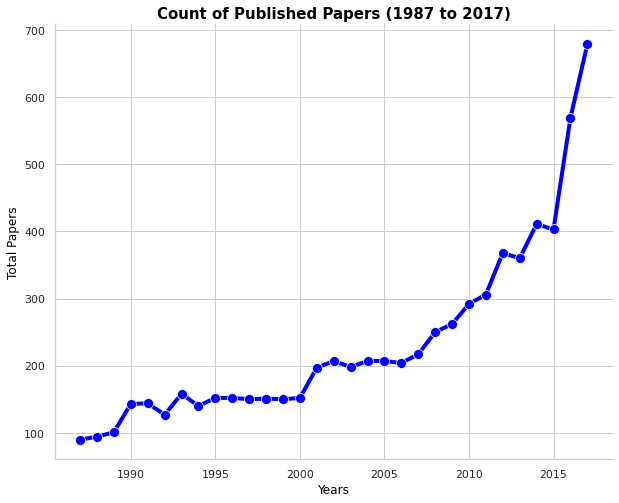

In [6]:
sns.set_theme(style='whitegrid')
fig,ax=plt.subplots(figsize=(10,8))

ax.spines['top'].set_visible(False);ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True);ax.spines['left'].set_visible(True)

sns.lineplot(data=papers['year'].value_counts(),marker='o',markersize=10,color='blue',linewidth=4)
ax.set_title("Count of Published Papers (1987 to 2017)",loc='center',color='black',fontsize=15,fontweight='semibold')
ax.set_xlabel("Years",loc='center',color='black',fontsize=12,fontweight='normal')
ax.set_ylabel("Total Papers",loc='center',color='black',fontsize=12,fontweight='normal')

from the line chart it is evident that total number of papers published in NeurIPS increasing drastically with the year. 

In further analysis I would basically focus on the title and the full text of the papers. To do so we have to clean and preprocess the data first. 


#### So, let's clean and preprocess the data

In [7]:
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


At first, let's create a user define function which will be used in future

In [8]:
nlp=spacy.load("en_core_web_sm")

def clean_string(text,stem="None"):
    final_string= ""
    
    #lowercasing the text
    text= text.lower() 
    
    #removing line breaks and hyphens
    text= re.sub(r'\n',' ',text) 
    text= re.sub(r'-',' ',text)
    
    #removing the punctuation
    translator= str.maketrans('','',string.punctuation)
    text= text.translate(translator) 
    
    #removing the stopwords
    text= text.split()
    stop_words= nltk.corpus.stopwords.words("english")
    text_filtered= [word for word in text if not word in stop_words]
    
    #removing the numbers
    text_filtered= [re.sub(r'\w*\d\w*','',w) for w in text_filtered]
    
    #stemming or lemmatizing
    if stem=='Stem':
        stemmer= PorterStemmer()
        text_stemmed= [stemmer.stem(w) for w in text_filtered]
        
    elif stem== 'Lem':
        lem= WordNetLemmatizer()
        text_stemmed= [lem.lemmatize(w) for w in text_filtered]
        
    elif stem== 'Spacy':
        text_filtered= nlp(' '.join(text_filtered))
        text_stemmed= [w.lemma_ for w in text_filtered]
        
    else:
        text_stemmed= text_filtered
        
    final_string= ' '.join(text_stemmed)
    return final_string

In [9]:
papers['CleanedTitle']= papers['title'].apply(lambda x: clean_string(x, stem= 'Lem'))
papers['CleanedTitle'].head()

0    self organization associative database applica...
1    mean field theory layer iv visual cortex appli...
2    storing covariance associative long term poten...
3     bayesian query construction neural network model
4    neural network ensemble cross validation activ...
Name: CleanedTitle, dtype: object

In [10]:
papers['CleanedFullText']= papers['paper_text'].apply(lambda x: clean_string(x, stem= 'Lem'))
papers['CleanedFullText'].head()

0     self organization associative database applic...
1     mean field theory layer iv visual cortex appl...
2     storing covariance associative longterm poten...
3    bayesian query construction neural network mod...
4    neural network ensemble cross validation activ...
Name: CleanedFullText, dtype: object

In [11]:
papers['CleanedFullText'][1]

' mean field theory layer iv visual cortex application artificial neural network christopher l scofield center neural science physic department brown university providence rhode island  nestor inc  richmond square providence rhode island  abstract single cell theory development selectivity ocular dominance visual cortex presented previously bienenstock cooper munrol extended network applicable layer iv visual cortex  paper present mean field approximation capture fairly transparent manner qualitative many quantitative result network theory finally consider application theory artificial neural network show significant reduction architectural complexity possible single layer network mean field approximation consider single layer network ideal neuron receive signal outside layer cell within layer figure  activity ith cell network   c j j j  cell vector afferent signal network receives input n fiber outside cortical network matrix synapsis mi intra layer input cell transmitted matrix corti

We have cleaned the title and full text of all the paper. The titles are looking fine but the full text required more cleaness which we will do in further step. Before that, let's create a wordcloud from the text of the title.

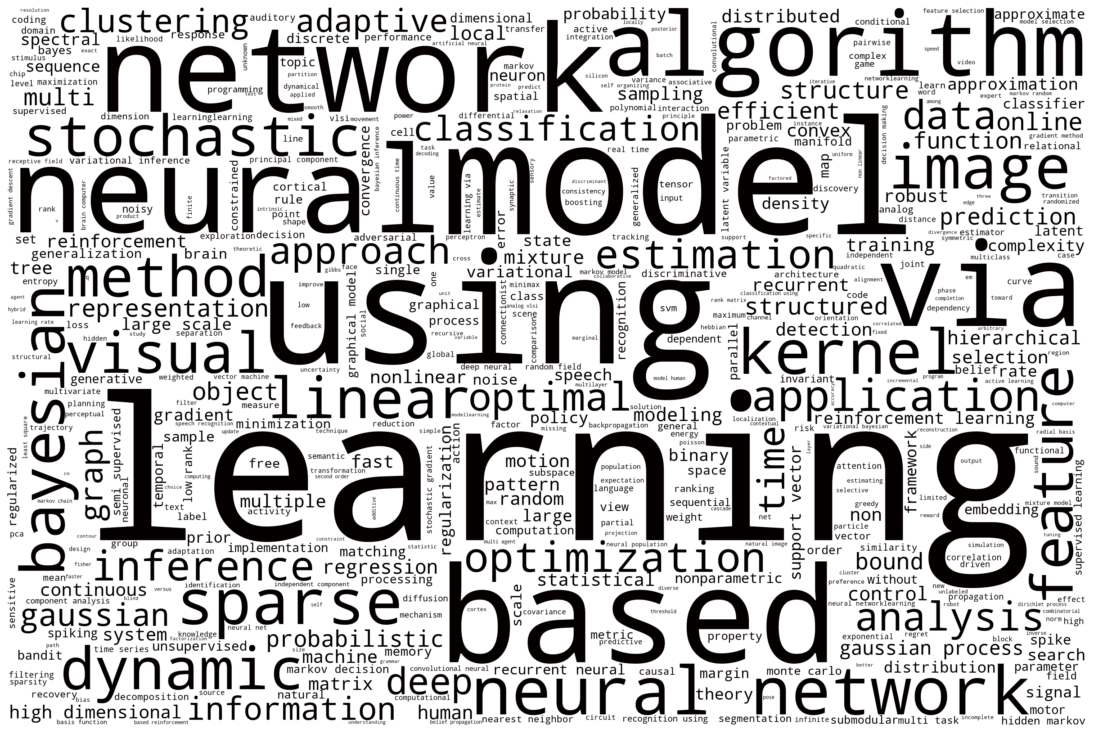

In [12]:
wordcloud=WordCloud(background_color="white",width=3000,height=2000,max_words=500).generate(''.join(papers["CleanedTitle"]))
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

wordcloud.recolor(color_func=black_color_func)

plt.figure(figsize=[15,10])
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)